# Annex 80 Weather Data Task Force Workshop - Day 1

## Extracting CORDEX Data from NETCDF4 Files

**Release history**

v0 : 2020-09-15

**License**

Licensed by La Rochelle University/LaSIE under a BSD 3 license (https://opensource.org/licenses/BSD-3-Clause).

**To use this code please cite the following publication:**

*Machard, A. , Inard, C., Alessandrini, J.M., Pelé, C., Ribéron, J.
A Methodology for Assembling Future Weather Files Including Heatwaves for Building Thermal Simulations from the European Coordinated Regional Downscaling Experiment (EURO-CORDEX) Climate Data*

https://www.mdpi.com/1996-1073/13/13/3424

**Data**

Data for this workshop were downloaded from the CORDEX Platform https://cordex.org/

In [1]:
# Importing Modules
from __future__ import division
import numpy as np
import netCDF4
import pandas as pd
from glob import glob
import xarray as xr
from netCDF4 import num2date

In [2]:
#### Declaring the coordinates of our city point (Here Trappes - rural station for Paris)
# City point must be the exact same one for which observations were collected
lat =  -23.5489
lonReal = -46.6388
alt = 760
lon = 360 + lonReal

In [3]:
# Inserting path where the .nc files are located
data_path = '/home/rodox/Downloads/esgf/'

In [4]:
# Importing the netcdf files and storing them in files
files = glob(data_path + "*.nc")

In [5]:
# Checking the files have been imported
files

['/home/rodox/Downloads/esgf/hurs_SAM-22_MPI-M-MPI-ESM-LR_historical_r1i1p1_GERICS-REMO2015_v1_3hr_200201010100-200212312200.nc',
 '/home/rodox/Downloads/esgf/tas_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_204701010100-204712312200.nc',
 '/home/rodox/Downloads/esgf/ps_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_204801010100-204812312200.nc',
 '/home/rodox/Downloads/esgf/ps_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_209401010100-209412312200.nc',
 '/home/rodox/Downloads/esgf/hurs_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_209801010100-209812312200.nc',
 '/home/rodox/Downloads/esgf/hurs_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_204101010100-204112312200.nc',
 '/home/rodox/Downloads/esgf/ps_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_209101010100-209112312200.nc',
 '/home/rodox/Downloads/esgf/hurs_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_204901010100-204912312200.nc',
 '

In [7]:
# Functions definitions

def get_name_var(path):
    # Getting the variable name by splitting the caracter chain
    name = path.split('_')[0].split('/')[-1]
    return name

def get_index(path):
    # Opening the path file as an xarray, getting the time index as a cftime index, converting it to a datetime index
    idx = xr.open_dataset(path).indexes['time'].to_pydatetime()
    return idx

# Variables definitions as empty lists
names, idxs = [], []

for f in files:
    n = get_name_var(f) # Calling the function get_name_var and storing the variables names of all .nc files in "names"
    names.append(n)

for f in files:
    i = get_index(f)  # Calling the function get_index and storing the indexes of all .nc files in "idxs"
    idxs.append(i)

In [8]:
# Printing the list names to make sure it contains all variable names
set(names)

{'hurs', 'huss', 'ps', 'rsds', 'sfcWind', 'tas'}

In [9]:
# Printing the lenght of the list to make sure all the file names have been imported
# We have 120 files and 120 names (20 years x 6 variables)
len(names)

360

In [10]:
len(idxs)

360

In [11]:
# Function definition
# This function opens the netcdf file, explores it, calculate the distance between each grid point and our city point
# & Gets the variable at the closest point of the grid to our city point

def get_data(file_path, variable, idx, lat=lat, lon=lon):
    
    print('File path:', file_path)
    print('Variable:',variable)
        
    # Opening the netCDF4 file and storing it in the variable nc
    nc = netCDF4.Dataset(file_path, mode='r')
    
    # Creating emptly lists of latitudes & longitudes
    list_lat, list_lon = [], []
    
    # Storing all the latitudes of the file in list_lat & all the longitudes in list_lon
    # Iterating through the 2 lists
    for (i,liste) in zip(['lat','lon'],[list_lat,list_lon]):
        # Iterating through the netCDF4 file (nc)
        for liste_i in nc.variables[i][:, :].tolist():
            liste+=[lat for lat in liste_i]

        print('Lenght of list_lat:',len(list_lat),'Length of list_lon:',len(list_lon))
       
    D = 9.E15
    # Creating v, a vector which contains our city point coordinates
    v = np.array([lat, lon])
    
    # Calculating, for each grid point (lat, lon) of the NETCDF4 file, the distance between that point & our city point
    for (lat_i,lon_j) in zip(list_lat,list_lon):
        # Calculating the distance using the function np.linalg.norm which calculates the norm of the vector
        Dij = np.linalg.norm(np.array([lat_i,lon_j]) - v)
        # If the distance is inferior to the distance stored before, we update lat0 & lon0
        # At the end of the loop, once we have compared all distances, the coordinates of the closest grid point 
        # are in lat0, lon0
        if Dij < D:
            lat0,lon0 = lat_i,lon_j
        # Updating D
        D = min(D,Dij)
    # Creating ij0, an array which containts the index of the closest grid point to our city point
    ij0 = np.where(nc.variables['lat'][:, :]==lat0)
    
    print('Smallest Distance D:',D)
    print('lat:',lat0)
    print('lon:',lon0)
    print('ij index:',ij0[0][0],ij0[1][0])
    
        
    # Storing in var the variable at the closest grid point to our city point: lat0, lon0
    var = nc.variables[variable][:,ij0[0][0], ij0[1][0]]
    print('Variable:',var)
        
    # Creating a pandas series that contains the variable associated to its time index
    s = pd.Series(var, index=idx)
        
    # Closing the NetCDF4 file
    nc.close()
    
    # Returnin the variable Series
    return s

In [12]:
# EXAMPLE for the 1st Temperature file #
linha = 2
a = get_data(files[linha], names[linha], idxs[linha],lat,lon);

File path: /home/rodox/Downloads/esgf/ps_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_204801010100-204812312200.nc
Variable: ps
Lenght of list_lat: 98325 Length of list_lon: 0
Lenght of list_lat: 98325 Length of list_lon: 98325
Smallest Distance D: 0.10143149659631362
lat: -23.452394485473633
lon: 313.3924255371094
ij index: 161 122
Variable: [64704.92  64642.766 64707.25  ... 64490.367 64488.78  64551.977]


In [13]:
# Printing our serie
a

2048-01-01 01:00:00    64704.921875
2048-01-01 04:00:00    64642.765625
2048-01-01 07:00:00    64707.250000
2048-01-01 10:00:00    64719.332031
2048-01-01 13:00:00    64686.410156
                           ...     
2048-12-31 10:00:00    64543.531250
2048-12-31 13:00:00    64472.570312
2048-12-31 16:00:00    64490.367188
2048-12-31 19:00:00    64488.781250
2048-12-31 22:00:00    64551.976562
Length: 2928, dtype: float32

In [14]:
# Converting Temperature from K to °C
s2 = a-273.15

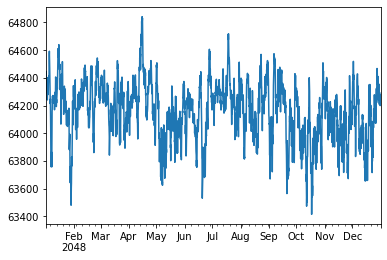

In [15]:
# Plotting Temperature
s2.plot()

## Please Run all the cells below AFTER the workshop as it will take some time to compute.

In [16]:
(files[0], names[0], idxs[0])

('/home/rodox/Downloads/esgf/hurs_SAM-22_MPI-M-MPI-ESM-LR_historical_r1i1p1_GERICS-REMO2015_v1_3hr_200201010100-200212312200.nc',
 'hurs',
 array([datetime.datetime(2002, 1, 1, 1, 0),
        datetime.datetime(2002, 1, 1, 4, 0),
        datetime.datetime(2002, 1, 1, 7, 0), ...,
        datetime.datetime(2002, 12, 31, 16, 0),
        datetime.datetime(2002, 12, 31, 19, 0),
        datetime.datetime(2002, 12, 31, 22, 0)], dtype=object))

In [17]:
# We create 6 empty series, one for each weather variable
# If your CORDEX domain do not have the cloud cover, delete cc
# If you have 3hourly data, we use specific humidity (huss), the relative humidity is not needed as we will recalculate it after the interpolation
# If you have hourly data, we use relative humidity (hurs)

import datetime
beg = datetime.datetime.now()

S_temp, S_hs, S_wind, S_cc, S_rs, S_pa = pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([])

# Iterating through each .nc file (list files), through each variable (list names), and through each year (list idxs)

for f, n, i in zip (files, names, idxs):
        
# Calling the function get_data
    
    # Storing the series with the data in new
    new = get_data(f, n, i)
        
    #print(new.head())
    
    # If the name of the series is tas, it will be added to the series temperature (S_temp)
    if n == 'tas':
        S_temp = S_temp.append(new)
        
    # If the name of the series is clt, it will be added to the series cloud cover (S_cc)
    if n == 'clt':
        S_cc = S_cc.append(new)
    # ...etc
    if n == 'huss':
        S_hs = S_hs.append(new)
    if n == 'ps':
        S_pa = S_pa.append(new)
    if n == 'rsds':
        S_rs = S_rs.append(new)
    if n == 'sfcWind':
        S_wind = S_wind.append(new)


end = datetime.datetime.now()

<ipython-input-17-aca9e3a9f53f>:9: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  S_temp, S_hs, S_wind, S_cc, S_rs, S_pa = pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([]), pd.Series([])


File path: /home/rodox/Downloads/esgf/hurs_SAM-22_MPI-M-MPI-ESM-LR_historical_r1i1p1_GERICS-REMO2015_v1_3hr_200201010100-200212312200.nc
Variable: hurs
Lenght of list_lat: 98325 Length of list_lon: 0
Lenght of list_lat: 98325 Length of list_lon: 98325
Smallest Distance D: 0.10143149659631362
lat: -23.452394485473633
lon: 313.3924255371094
ij index: 161 122
Variable: [58.274246 63.61003  56.708763 ... 45.463787 61.168255 84.199524]
File path: /home/rodox/Downloads/esgf/tas_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_204701010100-204712312200.nc
Variable: tas
Lenght of list_lat: 98325 Length of list_lon: 0
Lenght of list_lat: 98325 Length of list_lon: 98325
Smallest Distance D: 0.10143149659631362
lat: -23.452394485473633
lon: 313.3924255371094
ij index: 161 122
Variable: [281.3208  279.17157 278.2267  ... 295.1886  288.66687 284.37244]
File path: /home/rodox/Downloads/esgf/ps_SAM-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_3hr_204801010100-204812312200.nc
Variabl

In [18]:
# Changing some data units.
# Converting temperature from Kelvin to Celcius. 
S_temp = S_temp-273.15
# Converting cloud cover from 1/100 to 1/10 (Tenths)
S_cc = S_cc/10
# Converting humidity data from g/kg to kg/kg.
S_hs = S_hs*1000

In [19]:
# Merging all the data into a dataframe = A table with each variable (series) as a column
df = pd.DataFrame({'tas':S_temp, 'huss':S_hs, 'sfcWind':S_wind, 'rsds':S_rs, 'clt':S_cc, 'ps':S_pa})

In [20]:
# Path where to export the data as csv
path_out = '/home/rodox/Downloads/'
csv_full_path = path_out + '/data.csv'

## Exporting the data to path_out as .csv
df.to_csv(csv_full_path, index=True, header=True)

## Formatting & interpolating CORDEX climate data for building simulations

In [ ]:
import pvlib
from pvlib.location import Location

In [ ]:
path = csv_full_path

In [ ]:
df = pd.read_csv(path,index_col=0,header=0)
df.index = pd.to_datetime(df.index)

In [ ]:
# Function to interpolate the temperature every 30 min

def interpolate_30min_poly_temp(s, idx_30min):
    
    # Redindexing the series to 30min time-step and interpolating to 30min time-step
    s_30min = s.reindex(idx_30min).interpolate('polynomial',order=7)

    # Filling the 1st and 2nd values with the 3rd and the last 3 values with the last 4th value
    last = s_30min.iloc[len(s_30min)-4]
    s_30min.iloc[len(s_30min)-3:len(s_30min)] = [last, last, last]
    first = s_30min[2]
    s_30min[0] = first
    s_30min[1] = first
    
    return s_30min

In [ ]:
# Defining an index every 30 min
idx_30min = pd.date_range(start='1/1/2041', end='31/12/2060 23:30:00', freq='30min')
# Calling the function
dbt_30min = interpolate_30min_poly_temp(df['tas'], idx_30min)

In [ ]:
dbt_30min

In [ ]:
df['tas']['2041-01-03'].plot(marker="*")
dbt_30min['2041-01-03'].plot()

In [ ]:
# Function to interpolate the humidity, wind, atmospheric pressure and cloud cover (linear by default)

def interpolate_30min_linear_hs_wind_pa_cc(s, idx_30min):

    s_30min = s.reindex(idx_30min).interpolate(method='linear')
    # Filling the first 3 missing values
    s_30min[0] = s_30min[3]
    s_30min[1] = s_30min[3]
    s_30min[2] = s_30min[3]
        
    return s_30min

In [ ]:
sh_30min = interpolate_30min_linear_hs_wind_pa_cc(df['huss'], idx_30min)
ws_30min = interpolate_30min_linear_hs_wind_pa_cc(df['sfcWind'], idx_30min)
ap_30min = interpolate_30min_linear_hs_wind_pa_cc(df['ps'], idx_30min)
cc_30min = interpolate_30min_linear_hs_wind_pa_cc(df['clt'], idx_30min)

In [ ]:
sh_30min

In [ ]:
# Plotting specific humidity
df['huss']['2041-01-03'].plot(marker="*")
sh_30min['2041-01-03'].plot()

In [ ]:
ws_30min

In [ ]:
df['sfcWind']['2041-01-03'].plot(marker="*")
ws_30min['2041-01-03'].plot()

In [ ]:
ws_30min['2041'].plot()

In [ ]:
cc_30min['2041'].plot()

In [ ]:
ap_30min['2041'].plot()

In [ ]:
# Global Solar Radiation
gsr_30min = df['rsds'].reindex(idx_30min)

In [ ]:
# Winter Day in Paris
df['rsds']['2041-01-01'].plot(marker="*")

In [ ]:
# Summer Day in Paris
df['rsds']['2041-06-03'].plot(marker="*")

In [ ]:
# Getting the sun height from pvlib module
loc = Location(lat, lonReal, tz='UTC', altitude=alt, name='SP')
times_loc = idx_30min.tz_localize(loc.pytz, nonexistent='shift_backward', ambiguous=False)
sun_data = pvlib.solarposition.pyephem(times_loc, loc.latitude, loc.longitude)

In [ ]:
sun_data

In [ ]:
gsr_30min

In [ ]:
# Creating the dataframe df_sun with the global solar radiation rsds and the sun height h
df_sun = pd.DataFrame({'rsds':gsr_30min,'h':sun_data['elevation'].to_list()})

# WARNING: Because the sun values are average values, sometimes there is a data point when the sun is actually down.
# Creating the column gsr sun up in the dataframe
# If the sun height is < 0, gsr sun up = 0, otherwise gsr sun up = gsr
df_sun['rsds sun up'] = np.where(df_sun['h']<0,0,df_sun['rsds'])

# Creating the column gsr final up in the dataframe
# Interpolating from 3Hour to 30min
df_sun['rsds final'] = df_sun['rsds sun up'].interpolate(method='polynomial', order=2) 

In [ ]:
# Check for a winter day
df_sun['rsds']['2041-01-01'].plot(marker="*", legend=True)
df_sun['rsds final']['2041-01-01'].plot(legend=True)
df_sun['h']['2041-01-01'].plot(legend=True)

In [ ]:
# Check for a summer day
df_sun['rsds']['2041-06-03'].plot(marker="*", legend=True)
df_sun['rsds final']['2041-06-03'].plot(legend=True)
df_sun['h']['2041-06-03'].plot(legend=True)

In [ ]:
# Creating a dataframe with all data series
df_30min = pd.DataFrame({'tas':dbt_30min, 'huss':sh_30min, 'sfcWind':ws_30min, 'ps':ap_30min, 'clt':cc_30min, 'rsds':df_sun['rsds final'].to_list()})

In [ ]:
df_30min

In [ ]:
## Reindexing to 1HR
df_1H = df_30min.iloc[::2] 

In [ ]:
df_1H

In [ ]:
# Calculating the vapor pressure
df_1H['pv'] = ((df_1H['huss']/1000*df_1H['ps']/100)/(0.62198+df_1H['huss']/1000)) # PV is en hASP or mBar

# Calculating the saturated vapor pressure
df_1H.loc[df_1H['tas'] < 0, 'svp'] = 6.105 * np.exp((21.875*df_1H['tas'])/(265.5+df_1H['tas']))
df_1H.loc[df_1H['tas'] > 0, 'svp'] = 6.105 * np.exp((17.269*df_1H['tas'])/(237.3+df_1H['tas']))

# Calculating the Relative Humidity in percentage
df_1H['hurs'] = df_1H['pv']/df_1H ['svp']*100

In [ ]:
df_1H['pv']

In [ ]:
df_1H['svp']

In [ ]:
df_1H['hurs']

In [ ]:
df_1H['hurs']['2041'].plot()

In [ ]:
del df_1H['pv']
del df_1H['svp']

In [ ]:
df_1H

In [ ]:
# Exporting data to .csv
# WARNING: The data are in UTC
ville = 'SP'
path_out = r'C:/Users/LabEEE_1-4/Desktop/Workshop/nc_files'
df_1H.to_csv(path_out + '/' + '2020-09-15_WDTF_'+ville+'_'+'hourly-weather-data-CORDEX_2041-2060-rcp85.csv', index=True, header=True)